In [105]:
from No_sync.Frost_api import client_id, client_secret
import requests
import pandas as pd
from datetime import datetime, timedelta

<h2>API Call</h2>

In [106]:
# SN65320, SN65310, SN65370 
# Closest station gave error, so I used the second closest station
# air_temperature, precipitation_amount, wind_speed, relative_humidity, 

In [107]:
# Define the endpoint and parameters
endpoint = 'https://frost.met.no/observations/v0.jsonld'

# Calculate the date range for the last year
end_date = datetime.now()
start_date = end_date - timedelta(days=365)

# Format the date range as a string
date_range = start_date.strftime('%Y-%m-%d') + '/' + end_date.strftime('%Y-%m-%d')

parameters = {
    'sources': 'SN65370, SN65310',
    'elements': 'mean(air_temperature P1D),sum(precipitation_amount P1D),mean(wind_speed P1D),mean(relative_humidity P1D)',
    'referencetime': date_range,
}

# Issue an HTTP GET request
r = requests.get(endpoint, params=parameters, auth=(client_id, ''))

# Extract JSON data
json = r.json()


In [108]:
# Check if the request worked, print out any errors
if r.status_code == 200:
    data = json['data']
    print('Data retrieved from frost.met.no!')
else:
    print('Error! Returned status code %s' % r.status_code)
    print('Message: %s' % json['error']['message'])
    print('Reason: %s' % json['error']['reason'])

Data retrieved from frost.met.no!


<h2>From JSON to pandas dataframe</h2>

In [109]:
# make a dataframe
df_total = pd.DataFrame()
for i in range(len(data)):
    row = pd.DataFrame(data[i]['observations'])
    row['referenceTime'] = data[i]['referenceTime']
    row['sourceId'] = data[i]['sourceId']

    df_total = pd.concat([row, df_total])

In [110]:
# These additional columns will be kept
columns = ['sourceId','referenceTime','elementId','value','unit','timeOffset']
df = df_total[columns].copy()
# Convert the time value to something Python understands
df['referenceTime'] = pd.to_datetime(df['referenceTime'])

In [111]:
#get unique values in elementId
df['elementId'].unique()

array(['sum(precipitation_amount P1D)', 'mean(air_temperature P1D)',
       'mean(wind_speed P1D)', 'mean(relative_humidity P1D)'],
      dtype=object)

<h2>Plots for fun</h2>

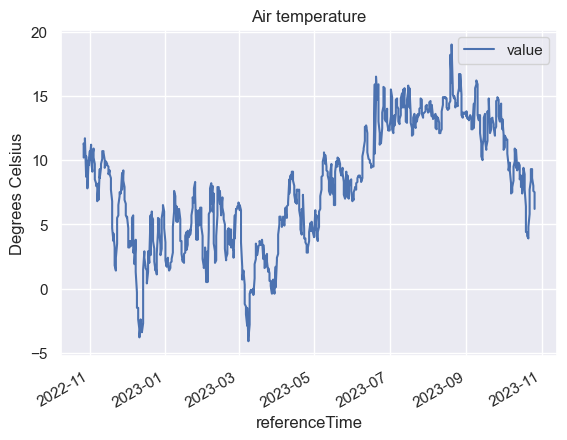

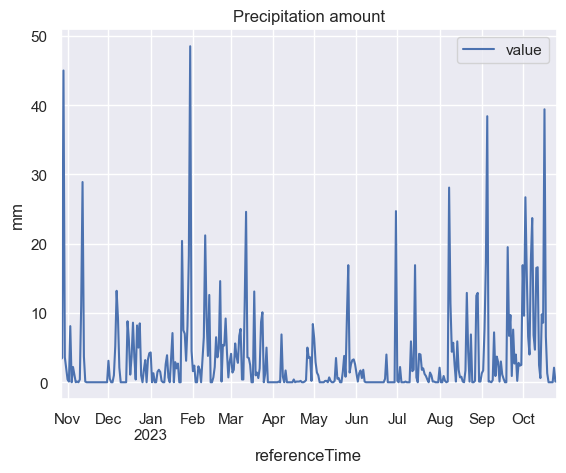

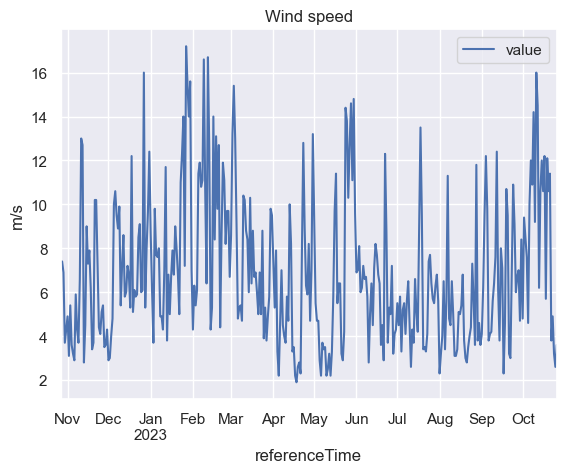

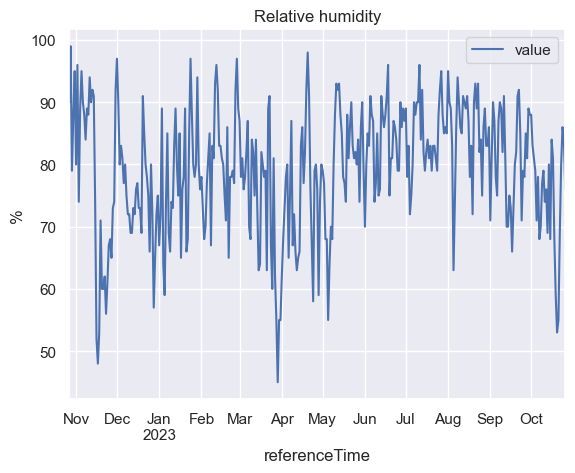

In [112]:
# plot values for each element based on time
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

# plot air_temperature
df_air_temperature = df[df['elementId'] == 'mean(air_temperature P1D)']
df_air_temperature = df_air_temperature[['referenceTime','value']]
df_air_temperature = df_air_temperature.set_index('referenceTime')
df_air_temperature.plot()
plt.title('Air temperature')
plt.ylabel('Degrees Celsius')
plt.show()

# plot precipitation_amount
df_precipitation_amount = df[df['elementId'] == 'sum(precipitation_amount P1D)']
df_precipitation_amount = df_precipitation_amount[['referenceTime','value']]
df_precipitation_amount = df_precipitation_amount.set_index('referenceTime')
df_precipitation_amount.plot()
plt.title('Precipitation amount')
plt.ylabel('mm')
plt.show()

# plot wind_speed
df_wind_speed = df[df['elementId'] == 'mean(wind_speed P1D)']
df_wind_speed = df_wind_speed[['referenceTime','value']]
df_wind_speed = df_wind_speed.set_index('referenceTime')
df_wind_speed.plot()
plt.title('Wind speed')
plt.ylabel('m/s')
plt.show()

# plot relative_humidity
df_relative_humidity = df[df['elementId'] == 'mean(relative_humidity P1D)']
df_relative_humidity = df_relative_humidity[['referenceTime','value']]
df_relative_humidity = df_relative_humidity.set_index('referenceTime')
df_relative_humidity.plot()
plt.title('Relative humidity')
plt.ylabel('%')
plt.show()




In [113]:
# Convert all column names to lower case
df.columns = df.columns.str.lower()

# make df to csv
df.to_csv('Data/weather.csv', index=False)

<h2>Connecting to Cassandra Cluster</h2>

In [114]:
# Connecting to Cassandra
from cassandra.cluster import Cluster
cluster = Cluster(['localhost'], port=9042)
session = cluster.connect()

In [115]:
# Creating a keyspace
session.execute("CREATE KEYSPACE IF NOT EXISTS fish_keyspace WITH REPLICATION = { 'class' : 'SimpleStrategy', 'replication_factor' : 1 };")

In [116]:
# set keyspace
session.set_keyspace('fish_keyspace')

In [117]:
# Drop the table if it already exists
session.execute("DROP TABLE IF EXISTS fish_keyspace.weather_table;") 

# Create a new table with primary keys
session.execute("""
   CREATE TABLE IF NOT EXISTS weather_table (
    sourceid TEXT,
    elementid TEXT,
    value DOUBLE,
    unit TEXT,
    timeoffset TEXT,
    referencetime DATE,
    PRIMARY KEY (elementid, timeoffset, referencetime)
);
""")


<h2>From Pandas dataframe to Spark dataframe</h2>

In [118]:
import os
os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk-20"
# If you are using environments in Python, you can set the environment variables like this:
os.environ["PYSPARK_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
#os.environ["PYSPARK_DRIVER_PYTHON"] = "python" # or similar to "/Users/kristian/miniforge3/envs/tf_M1/bin/python"
# Set the Hadoop version to the one you are using, e.g., none:
#os.environ["PYSPARK_HADOOP_VERSION"] = "without"

In [119]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('SparkCassandraApp').\
    config('spark.jars.packages', 'com.datastax.spark:spark-cassandra-connector_2.12:3.4.1').\
    config('spark.cassandra.connection.host', 'localhost').\
    config('spark.sql.extensions', 'com.datastax.spark.connector.CassandraSparkExtensions').\
    config('spark.sql.catalog.mycatalog', 'com.datastax.spark.connector.datasource.CassandraCatalog').\
    config('spark.cassandra.connection.port', '9042').getOrCreate()
# Some warnings are to be expected.

In [120]:
# Read the data from the csv files
weather_data = spark.read.csv('Data/weather.csv', header=True, inferSchema=True)

In [121]:
# Write the data to Cassandra
keyspace = "fish_keyspace"
table = "weather_table"

weather_data.write \
    .format("org.apache.spark.sql.cassandra") \
    .option("table", table) \
    .option("keyspace", keyspace) \
    .mode("append").save()

In [122]:
# Read from Cassandra - fish_table_year
df_weather = spark.read.format("org.apache.spark.sql.cassandra").options(table="weather_table", keyspace="fish_keyspace").load()
df_weather.show()

+--------------------+----------+-------------+---------+----+-----+
|           elementid|timeoffset|referencetime| sourceid|unit|value|
+--------------------+----------+-------------+---------+----+-----+
|mean(wind_speed P1D)|      PT0H|   2022-10-27|SN65310:0| m/s|  7.4|
|mean(wind_speed P1D)|      PT0H|   2022-10-28|SN65310:0| m/s|  7.4|
|mean(wind_speed P1D)|      PT0H|   2022-10-29|SN65310:0| m/s|  6.9|
|mean(wind_speed P1D)|      PT0H|   2022-10-30|SN65310:0| m/s|  3.7|
|mean(wind_speed P1D)|      PT0H|   2022-10-31|SN65310:0| m/s|  4.3|
|mean(wind_speed P1D)|      PT0H|   2022-11-01|SN65310:0| m/s|  4.9|
|mean(wind_speed P1D)|      PT0H|   2022-11-02|SN65310:0| m/s|  3.1|
|mean(wind_speed P1D)|      PT0H|   2022-11-03|SN65310:0| m/s|  5.4|
|mean(wind_speed P1D)|      PT0H|   2022-11-04|SN65310:0| m/s|  3.6|
|mean(wind_speed P1D)|      PT0H|   2022-11-05|SN65310:0| m/s|  3.2|
|mean(wind_speed P1D)|      PT0H|   2022-11-06|SN65310:0| m/s|  2.9|
|mean(wind_speed P1D)|      PT0H| 

In [123]:
# make a pandas dataframe
df_weather = df_weather.toPandas()

In [124]:
# get the first date in the week
df_weather['referencetime'] = pd.to_datetime(df_weather['referencetime'])
df_weather['week'] = df_weather['referencetime'].dt.isocalendar().week
df_weather['year'] = df_weather['referencetime'].dt.isocalendar().year

<h1>Part 2 - transform data

In [125]:
# read from Cassandra - fish_table_year 
lice_count_table = spark.read.format("org.apache.spark.sql.cassandra").options(table="lice_count_table", keyspace="fish_keyspace").load()

# turn the dataframes into pandas dataframes
lice_count_table = lice_count_table.toPandas()

# drop columns where all values are null or nan
lice_count_table = lice_count_table.dropna(axis=1, how='all')

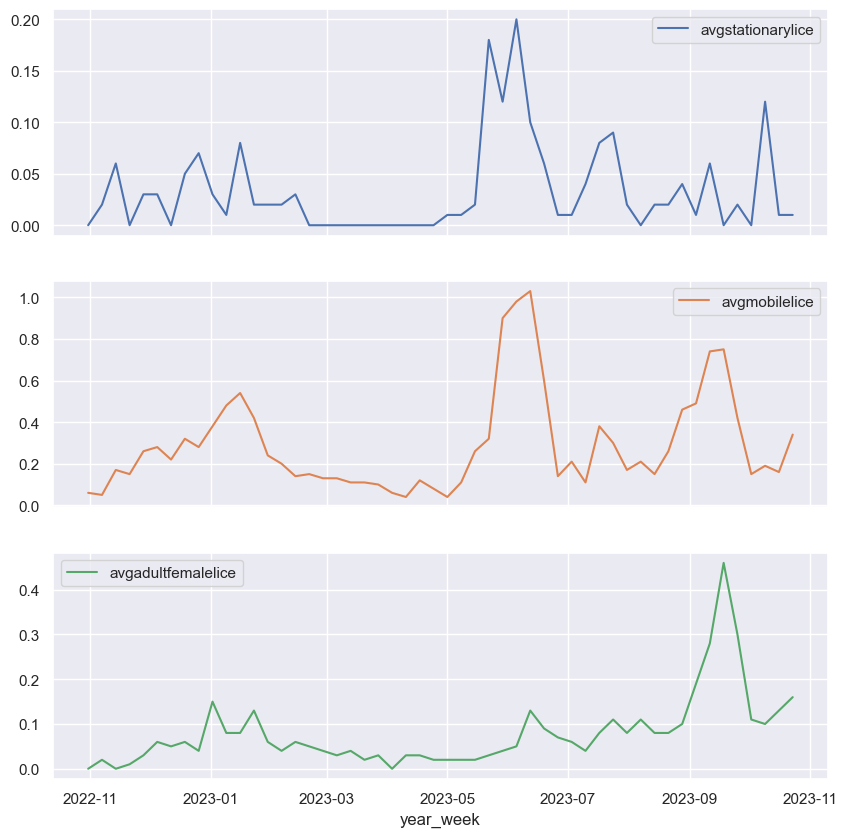

In [126]:
# plot avgstationarylice, avgmobilelice, avgfemalelice based on year_week, in 3 subplots
lice_count_table_plot = lice_count_table[['year_week','avgstationarylice','avgmobilelice','avgadultfemalelice']]
lice_count_table_plot = lice_count_table_plot.set_index('year_week')
lice_count_table_plot.plot(subplots=True, figsize=(10,10))

plt.show()

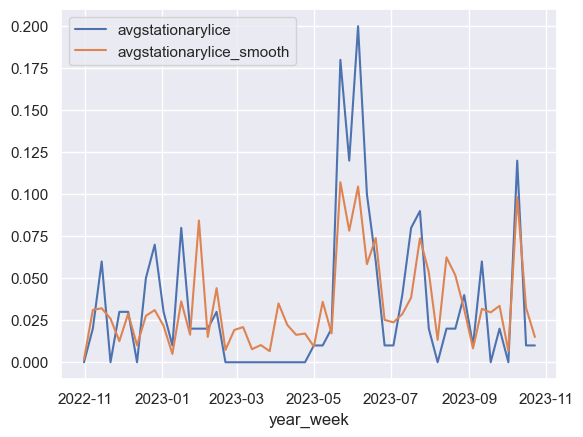

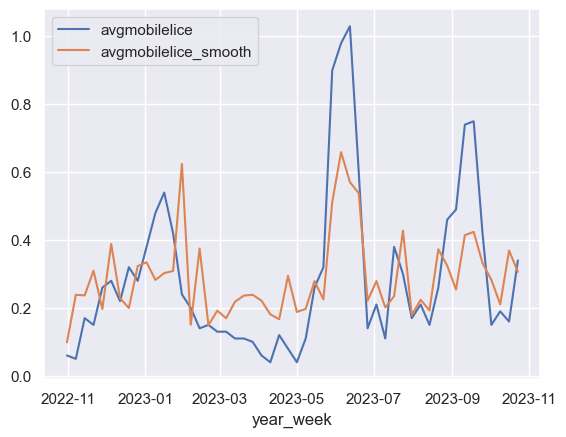

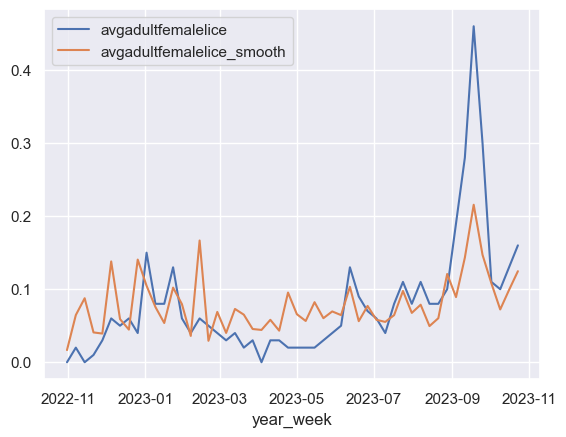

In [127]:
# do the same with gaussian filter
from scipy.ndimage import gaussian_filter1d
lice_count_table_plot = lice_count_table_plot.reset_index()

lice_count_table_plot['avgstationarylice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgstationarylice'], sigma=1)
lice_count_table_plot['avgmobilelice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgmobilelice'], sigma=1)
lice_count_table_plot['avgadultfemalelice_smooth'] = gaussian_filter1d(lice_count_table_plot['avgadultfemalelice'], sigma=1)

lice_count_table_plot = lice_count_table_plot.set_index('year_week')
lice_count_table_plot[['avgstationarylice','avgstationarylice_smooth']].plot()
lice_count_table_plot[['avgmobilelice','avgmobilelice_smooth']].plot()
lice_count_table_plot[['avgadultfemalelice','avgadultfemalelice_smooth']].plot()
plt.show()

#### sigma = 1 was the best smoothing parameter, the rest became a flat line

In [128]:
# Compute robust means and robust covariance for the raw data.
from sklearn.covariance import MinCovDet
robust_cov = MinCovDet().fit(lice_count_table_plot[['avgstationarylice','avgmobilelice','avgadultfemalelice']])
robust_mean = robust_cov.location_
robust_covariance = robust_cov.covariance_

# print the results
print('Robust location:')
print(robust_mean)
print('\nRobust covariance matrix:')
print(robust_covariance)

Robust location:
[0.01314286 0.17657143 0.05371429]

Robust covariance matrix:
[[0.00019869 0.00088506 0.00017404]
 [0.00088506 0.0105311  0.00251845]
 [0.00017404 0.00251845 0.00142906]]


In [129]:
# define function for Hotelling's T2
def Hotellings_T2(X, mean, cov, n, alpha = 0.01):
    T2 = np.sum(((X-mean) @ np.linalg.inv(cov)) * (X-mean), axis=-1)
    p = len(mean)
    F = (n-p)/(p*(n-1))*T2
    P = stats.f.sf(F, p, n-p)
    # Critical value
    c = stats.f.isf(alpha, p, n-p)*p*(n-1)/(n-p)
    return (T2, F, P, c)



In [130]:
# get relevant data
pdata = lice_count_table_plot[['avgstationarylice','avgmobilelice','avgadultfemalelice']].to_numpy()

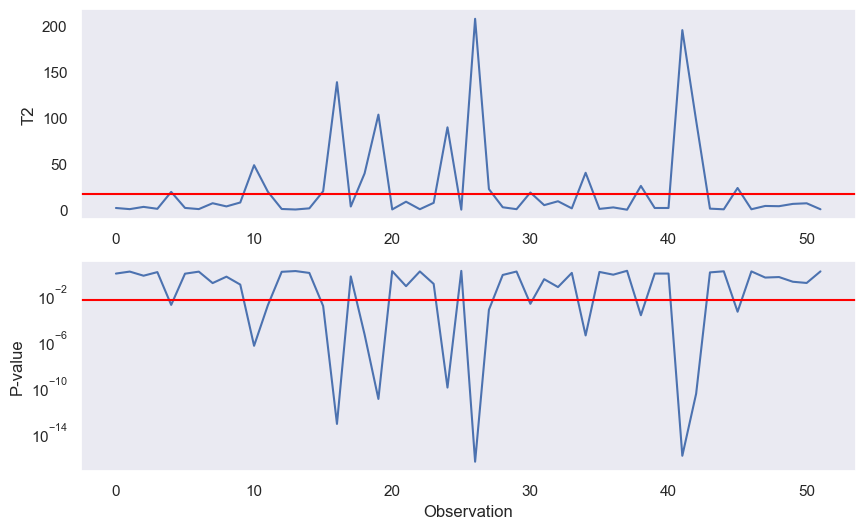

In [131]:
# import stats
from scipy import stats
#import numpy
import numpy as np
# Apply Hotellings_T2 and plot

alpha = 0.0027
T2, F, P, c = Hotellings_T2(pdata, robust_mean, robust_covariance, 52, alpha)
plt.figure(figsize=(10,6))
plt.subplot(211)
plt.plot(T2)
plt.grid()
plt.axhline(c, color="red")

plt.ylabel("T2")
plt.subplot(212)
# Plot P on a logarithmic scale
plt.plot(P)
plt.yscale("log")
plt.grid()
plt.axhline(alpha, color="red")

plt.ylabel("P-value")
plt.xlabel("Observation")
plt.show()

In [132]:
# combine year and week into one column in lice_count_table
lice_count_table['year_week'] = lice_count_table['year'].astype(str) +'_'+ lice_count_table['week'].astype(str)

<h3> Weather data transforming

In [133]:
df_weather.dtypes


elementid                object
timeoffset               object
referencetime    datetime64[ns]
sourceid                 object
unit                     object
value                   float64
week                     UInt32
year                     UInt32
dtype: object

In [134]:
# sync the dataframe lice_table_year_plot with weather_table
df_weather.head(10)


,elementid,timeoffset,referencetime,sourceid,unit,value,week,year
0,sum(precipitation_amount P1D),PT6H,2022-10-27,SN65370:0,mm,3.3,43,2022
1,sum(precipitation_amount P1D),PT6H,2022-10-28,SN65370:0,mm,3.5,43,2022
2,sum(precipitation_amount P1D),PT6H,2022-10-29,SN65370:0,mm,45.0,43,2022
3,sum(precipitation_amount P1D),PT6H,2022-10-30,SN65370:0,mm,3.6,43,2022
4,sum(precipitation_amount P1D),PT6H,2022-10-31,SN65370:0,mm,2.0,44,2022
5,sum(precipitation_amount P1D),PT6H,2022-11-01,SN65370:0,mm,0.4,44,2022
6,sum(precipitation_amount P1D),PT6H,2022-11-02,SN65370:0,mm,0.1,44,2022
7,sum(precipitation_amount P1D),PT6H,2022-11-03,SN65370:0,mm,8.1,44,2022
8,sum(precipitation_amount P1D),PT6H,2022-11-04,SN65370:0,mm,0.0,44,2022
9,sum(precipitation_amount P1D),PT6H,2022-11-05,SN65370:0,mm,2.2,44,2022


In [135]:
# combine the year and week columns to one column
df_weather['year_week'] = df_weather['year'].astype(str) + '_' + df_weather['week'].astype(str)


In [136]:
df_weather.shape


(1825, 9)

In [137]:
# gruop by referencetime
df_weather = df_weather.groupby(['referencetime','elementid', 'week', 'year','unit', 'sourceid', 'year_week'] )
df_weather = df_weather['value'].mean()


In [138]:
df_weather = df_weather.reset_index()

In [139]:
# Pivot the DataFrame based on the 'elementid' column
pivoted_df = df_weather.pivot(index=['referencetime', 'week', 'year', 'year_week'], columns='elementid', values='value')

# Reset the index to the default integer index
pivoted_df = pivoted_df.reset_index()

# Display the pivoted DataFrame
pivoted_df.head(10)

# gruop by referencetime
pivoted_df = pivoted_df.groupby(['referencetime','week', 'year', 'year_week'] )

In [140]:
pivoted_df = pivoted_df.mean().reset_index()

In [141]:
# drop week, year and year_week
pivoted_df = pivoted_df.drop(['week', 'year'], axis=1)

In [142]:
#drop index
pivoted_df = pivoted_df.reset_index(drop=True)

In [143]:
#set referencetime as index
pivoted_df = pivoted_df.set_index('referencetime')

In [144]:
# columnes to mean
columns_to_mean = ['mean(air_temperature P1D)', 'mean(relative_humidity P1D)', 'mean(wind_speed P1D)']
columns_to_sum = ['sum(precipitation_amount P1D)']

df_weekly = pivoted_df[columns_to_mean].resample('W').mean()
df_weekly['sum(precipitation_amount P1D)'] = pivoted_df[columns_to_sum].resample('W').sum()

In [145]:
df_weekly['week'] = pivoted_df['year_week']

In [146]:
# drop if row includes nan
df_weekly = df_weekly.dropna(axis=0, how='any')

<h3>Combine the two df<h3>

In [147]:
#reset index
df_weekly = df_weekly.reset_index()
lice_count_table = lice_count_table.reset_index()

In [148]:
# inner join the two dataframes on week column in df_weekly and year_week column in lice_count_table
combine_df = pd.merge(df_weekly, lice_count_table, how='inner', left_on='week', right_on='year_week')

In [149]:
# keep referencetime	mean(air_temperature P1D)	mean(relative_humidity P1D)	mean(wind_speed P1D)	sum(precipitation_amount P1D) avgadultfemalelice	avgmobilelice	avgstationarylice	localityname
columns_to_keep = ['referencetime', 'mean(air_temperature P1D)', 'mean(relative_humidity P1D)', 'mean(wind_speed P1D)', 'sum(precipitation_amount P1D)', 'avgadultfemalelice', 'avgmobilelice', 'avgstationarylice', 'localityname']
combine_df = combine_df[columns_to_keep]


In [150]:
combine_df.columns = combine_df.columns.str.lower()

column_mapping = {
    'referencetime': 'referencetime',
    'mean(air_temperature p1d)': 'mean_air_temperature',
    'mean(relative_humidity p1d)': 'mean_relative_humidity',
    'mean(wind_speed p1d)': 'mean_wind_speed',
    'sum(precipitation_amount p1d)': 'sum_precipitation_amount',
    'avgadultfemalelice': 'avgadultfemalelice',
    'avgmobilelice': 'avgmobilelice',
    'avgstationarylice': 'avgstationarylice',
    'localityname': 'localityname'
}

# Assuming df is your DataFrame
combine_df = combine_df.rename(columns=column_mapping)
# save as csv
combine_df.to_csv('Data/combine_df.csv', index=False)


In [151]:
combine_df.head(10)

,referencetime,mean_air_temperature,mean_relative_humidity,mean_wind_speed,sum_precipitation_amount,avgadultfemalelice,avgmobilelice,avgstationarylice,localityname
0,2022-11-06,9.750000,88.428571,3.914286,13.9,0.00,0.06,0.00,Andholmen 1
1,2022-11-13,9.164286,89.285714,7.000000,44.2,0.02,0.05,0.02,Andholmen 1
2,2022-11-20,7.950000,64.142857,6.000000,0.1,0.00,0.17,0.06,Andholmen 1
3,2022-11-27,5.450000,62.714286,6.685714,0.0,0.01,0.15,0.00,Andholmen 1
4,2022-12-04,5.542857,84.142857,3.728571,3.6,0.03,0.26,0.03,Andholmen 1
5,2022-12-11,1.071429,75.142857,8.785714,30.7,0.06,0.28,0.03,Andholmen 1
6,2022-12-18,0.114286,73.285714,7.414286,19.7,0.05,0.22,0.00,Andholmen 1
7,2022-12-25,3.264286,77.714286,6.642857,35.3,0.06,0.32,0.05,Andholmen 1
8,2023-01-01,4.528571,69.714286,9.457143,16.8,0.04,0.28,0.07,Andholmen 1
9,2023-01-08,2.864286,73.142857,6.828571,6.1,0.15,0.38,0.03,Andholmen 1


In [152]:
# drop the table if it already exists
session.execute("DROP TABLE IF EXISTS fish_keyspace.combine_table;")
# Create a new table with primary keys
session.execute("""
   CREATE TABLE IF NOT EXISTS combine_table (
    referencetime DATE PRIMARY KEY,
    mean_air_temperature DOUBLE,
    mean_relative_humidity DOUBLE,
    mean_wind_speed DOUBLE,
    sum_precipitation_amount DOUBLE,
    avgadultfemalelice DOUBLE,
    avgmobilelice DOUBLE,
    avgstationarylice DOUBLE,
    localityname TEXT
);
""")

In [153]:
# read the data from the csv file
combine_df = spark.read.csv('Data/combine_df.csv', header=True, inferSchema=True)

In [154]:
# Write the data to Cassandra
keyspace = "fish_keyspace"
table = "combined_table"

combine_df.write \
    .format("org.apache.spark.sql.cassandra") \
    .option("table", table) \
    .option("keyspace", keyspace) \
    .mode("append").save()

In [155]:
# read from Cassandra - combined_table
df_combine = spark.read.format("org.apache.spark.sql.cassandra").options(table="combined_table", keyspace="fish_keyspace").load()
df_combine.show()

+-------------+------------------+-------------+-----------------+------------+--------------------+----------------------+------------------+------------------------+
|referencetime|avgadultfemalelice|avgmobilelice|avgstationarylice|localityname|mean_air_temperature|mean_relative_humidity|   mean_wind_speed|sum_precipitation_amount|
+-------------+------------------+-------------+-----------------+------------+--------------------+----------------------+------------------+------------------------+
|   2023-08-20|              0.08|         0.15|             0.02| Andholmen 1|  15.178571428571429|     84.28571428571429| 4.642857142857143|                    11.0|
|   2023-04-23|              0.03|         0.12|              0.0| Andholmen 1|  6.1000000000000005|     83.28571428571429| 4.642857142857143|                     0.5|
|   2023-06-04|              0.04|          0.9|             0.12| Andholmen 1|   7.678571428571429|     81.85714285714286| 9.071428571428571|                  